# Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [11]:
DATA='EURUSD'

# extended_columns = [str(num)+'h' for num in np.arange(1,25)]
# extended_columns
# names=['time','currency','description','impact','actual','deviation','consensus','previous','result'].extend()

In [12]:
frame = pd.read_csv('./data/economic_events_'+DATA+'.csv',header=0,parse_dates=['time'],index_col='time',date_format='%y-%m-%d %H:%M:%S%Z')
frame.rename(columns={'hex_color_actual':'result'},inplace=True)

In [14]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29545 entries, 2013-01-02 09:13:00+00:00 to 2024-06-06 15:30:00+01:00
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     29545 non-null  object 
 1   description  29545 non-null  object 
 2   impact       29545 non-null  object 
 3   actual       29545 non-null  object 
 4   deviation    29545 non-null  object 
 5   consensus    29545 non-null  object 
 6   previous     29545 non-null  object 
 7   result       29545 non-null  object 
 8   1h           29539 non-null  float64
 9   2h           29492 non-null  float64
 10  3h           29460 non-null  float64
 11  4h           29435 non-null  float64
 12  5h           29408 non-null  float64
 13  6h           29379 non-null  float64
 14  7h           29105 non-null  float64
 15  8h           28223 non-null  float64
 16  9h           27287 non-null  float64
 17  10h          26968 non-null  float64
 18  11h    

In [8]:
frame.describe()

,currency,description,impact,actual,deviation,consensus,previous,result
count,372768,372768,372768,372768,372768,372768,372768,372768
unique,34,7059,4,11095,1815,8980,11080,3
top,EUR,Consumer Price Index (YoY)(Jan),low,0.2%,0.00,0.2%,0.2%,green
freq,102150,1032,209052,9102,64566,12978,9102,157974


In [21]:
frame.columns

Index(['currency', 'description', 'impact', 'actual', 'deviation', 'consensus',
       'previous', 'result', '1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h',
       '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h',
       '19h', '20h', '21h', '22h', '23h', '24h'],
      dtype='object')

In [22]:
frame.shape

(29545, 32)

In [23]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29545 entries, 2013-01-02 09:13:00+00:00 to 2024-06-06 15:30:00+01:00
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   currency     29545 non-null  object 
 1   description  29545 non-null  object 
 2   impact       29545 non-null  object 
 3   actual       29545 non-null  object 
 4   deviation    29545 non-null  object 
 5   consensus    29545 non-null  object 
 6   previous     29545 non-null  object 
 7   result       29545 non-null  object 
 8   1h           29539 non-null  float64
 9   2h           29492 non-null  float64
 10  3h           29460 non-null  float64
 11  4h           29435 non-null  float64
 12  5h           29408 non-null  float64
 13  6h           29379 non-null  float64
 14  7h           29105 non-null  float64
 15  8h           28223 non-null  float64
 16  9h           27287 non-null  float64
 17  10h          26968 non-null  float64
 18  11h    

In [24]:
frame.head()

,currency,description,impact,actual,deviation,consensus,previous,result,1h,2h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 09:13:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,-0.48,45.1,45.3,red,1.32448,1.32479,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:43:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,46.7,1.20,45.3,45.1,green,1.32448,1.32479,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:48:00+00:00,EUR,HCOB Manufacturing PMI(Dec),low,44.6,0.00,44.6,44.6,black,1.32448,1.32479,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:53:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46,-0.28,46.3,46.3,red,1.32448,1.32479,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147
2013-01-02 09:58:00+00:00,EUR,HCOB Manufacturing PMI(Dec),medium,46.1,-0.32,46.3,46.3,red,1.32448,1.32479,...,1.31821,1.31703,1.31267,1.31387,1.31371,1.31382,1.31452,1.31339,1.31636,1.3147


In [25]:
frame.tail()

,currency,description,impact,actual,deviation,consensus,previous,result,1h,2h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2024-06-06 13:30:00+01:00,USD,Goods and Services Trade Balance(Apr),low,$-74.6B,0.79,$-76.1B,$-68.6B,green,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 13:30:00+01:00,USD,Initial Jobless Claims(May 31),medium,229K,0.96,220K,221K,red,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 13:30:00+01:00,USD,Nonfarm Productivity(Q1),medium,0.2%,0.24,0.1%,0.3%,green,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 13:30:00+01:00,USD,Unit Labor Costs(Q1),medium,4%,-0.86,4.9%,4.7%,red,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 15:30:00+01:00,USD,EIA Natural Gas Storage Change(May 31),low,98B,1.55,89B,84B,red,1.08816,1.08815,...,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328,1.08190,1.08121


,currency,description,impact,actual,deviation,consensus,previous,result,1h,2h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-11-01 22:00:00+00:00,USD,Total Vehicle Sales(Oct),low,15.23M,-0.50,15.45M,15.21M,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03 23:00:00+00:00,USD,Total Vehicle Sales(Dec),low,15.4M,-1.20,16M,16.4M,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01 21:30:00+00:00,USD,Total Vehicle Sales(Jan),low,16.7M,-2.27,17.2M,17.55M,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-01 21:30:00+00:00,USD,Total Vehicle Sales(Feb),low,16.57M,-0.61,16.8M,16.7M,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-20 14:30:00+00:00,EUR,Unemployment Rate(Dec),low,5.1%,0.65,5.05%,5%,red,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-01 22:30:00+00:00,USD,Total Vehicle Sales(Jan),low,15.8M,1.44,15.4M,15M,green,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [26]:
frame.currency.value_counts()

currency
EUR    17096
USD    12449
Name: count, dtype: int64

In [27]:
frame[['currency','impact']].value_counts()

currency  impact
EUR       low       10235
USD       medium     6058
EUR       medium     5343
USD       low        4774
          high       1616
EUR       high       1515
          none          3
USD       none          1
Name: count, dtype: int64

In [28]:
frame.description.value_counts()

description
ECB Main Refinancing Operations Rate      96
Fed Interest Rate Decision                85
ECB Rate On Deposit Facility              68
HCOB Manufacturing PMI(May)               61
HCOB Manufacturing PMI(Apr)               61
                                          ..
Initial Jobless Claims(Aug 24)             1
EIA Natural Gas Storage Change(Aug 24)     1
Initial Jobless Claims(Aug 31)             1
EIA Natural Gas Storage Change(Aug 31)     1
API Weekly Crude Oil Stock(May 31)         1
Name: count, Length: 3840, dtype: int64

In [29]:
frame.description.unique().shape

(3840,)

In [30]:
frame[['currency','impact','result']].value_counts()

currency  impact  result
EUR       low     green     4060
                  red       3958
USD       medium  green     2769
                  red       2629
EUR       low     black     2217
USD       low     red       2205
                  green     2185
EUR       medium  green     2177
                  red       2017
                  black     1149
USD       high    green      680
          medium  black      660
          high    red        616
EUR       high    black      587
                  green      464
                  red        464
USD       low     black      384
          high    black      320
EUR       none    green        3
USD       none    green        1
Name: count, dtype: int64

In [31]:
frame.currency.unique()

array(['EUR', 'USD'], dtype=object)

# Visualization

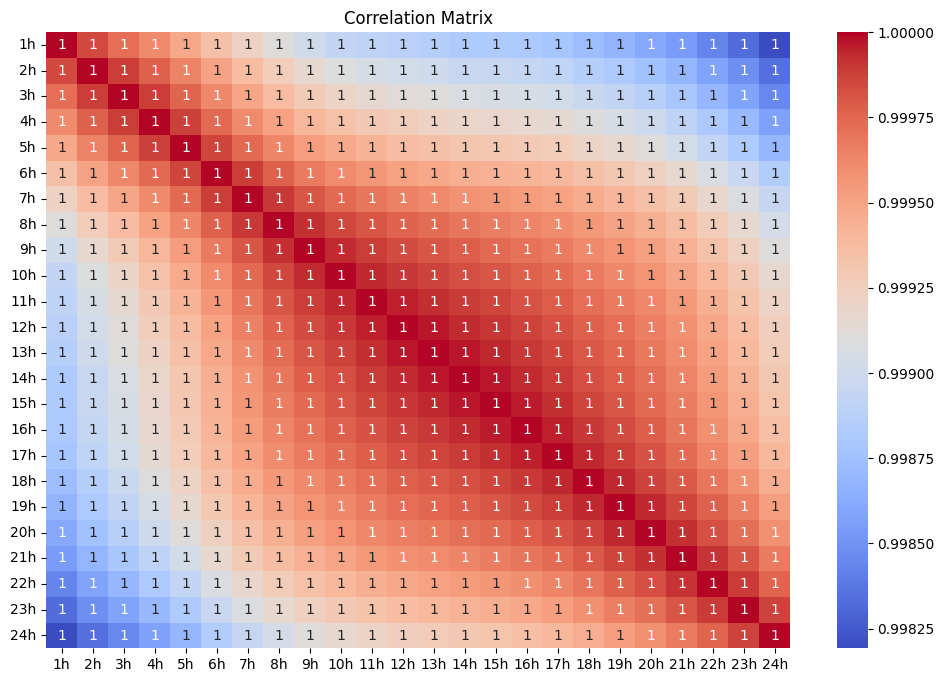

In [32]:
# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = frame[[str(hour) +'h' for hour in np.arange(1,25) ]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



In [42]:
frame.index.duplicated()


array([False, False, False, ...,  True,  True, False])

In [43]:
frame.loc[frame.index.duplicated(), :]

,currency,description,impact,actual,deviation,consensus,previous,result,1h,2h,...,15h,16h,17h,18h,19h,20h,21h,22h,23h,24h
time,,,,,,,,,,,,,,,,,,,,,
2013-01-02 14:00:00+00:00,EUR,Consumer Price Index (YoY)(Dec) PREL,high,2.1%,0.00,1.9%,1.9%,green,1.32535,1.32386,...,1.31371,1.31382,1.31452,1.31339,1.31636,1.31470,1.30956,1.31120,1.30980,1.31105
2013-01-02 14:00:00+00:00,EUR,Harmonized Index of Consumer Prices (MoM)(Dec)...,medium,1%,1.96,0.8%,-0.2%,green,1.32535,1.32386,...,1.31371,1.31382,1.31452,1.31339,1.31636,1.31470,1.30956,1.31120,1.30980,1.31105
2013-01-02 14:00:00+00:00,EUR,Harmonized Index of Consumer Prices (YoY)(Dec)...,high,2.1%,1.12,2%,1.9%,green,1.32535,1.32386,...,1.31371,1.31382,1.31452,1.31339,1.31636,1.31470,1.30956,1.31120,1.30980,1.31105
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing PMI(Dec),high,50.2,-0.09,50.3,48,red,1.31945,1.31688,...,1.31452,1.31339,1.31636,1.31470,1.30956,1.31120,1.30980,1.31105,1.30997,1.30942
2013-01-02 16:00:00+00:00,USD,ISM Manufacturing Prices Paid(Dec),medium,55.5,1.18,51.5,52.1,green,1.31945,1.31688,...,1.31452,1.31339,1.31636,1.31470,1.30956,1.31120,1.30980,1.31105,1.30997,1.30942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-06 13:15:00+01:00,EUR,ECB Rate On Deposit Facility,high,3.75%,0.00,3.75%,4%,black,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 13:30:00+01:00,USD,Goods and Services Trade Balance(Apr),low,$-74.6B,0.79,$-76.1B,$-68.6B,green,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328
2024-06-06 13:30:00+01:00,USD,Initial Jobless Claims(May 31),medium,229K,0.96,220K,221K,red,1.08847,1.08776,...,1.08942,1.08950,1.08901,1.08919,1.08923,1.08885,1.08911,1.08883,1.08979,1.08328


ValueError: cannot reindex on an axis with duplicate labels

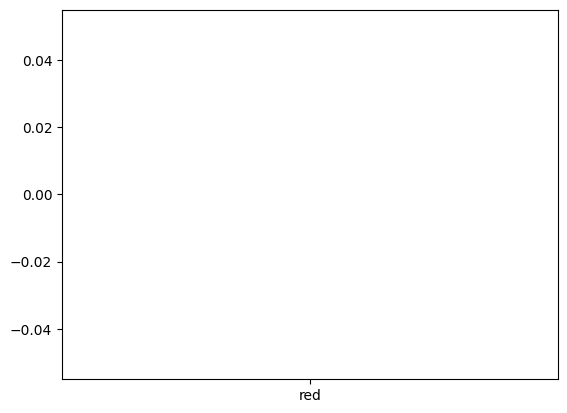

In [40]:
# Visualize the impact of 'impact' on EURUSD prices
frame.columns
sns.boxplot(x='result', y='15h', data=frame)
plt.title('Impact on EURUSD Prices after 1 Hour')
plt.show()

In [33]:
frame['deviation'] = frame.deviation.replace('-',None).astype(np.float64)

In [64]:
frame.deviation.value_counts().tail()

deviation
-7.42     1
-7.91     1
 14.75    1
-9.61     1
 5.11     1
Name: count, dtype: int64

In [65]:
frame.result.value_counts()

result
green    7729
red      7565
black    2026
Name: count, dtype: int64

# Handling missing Data

In [46]:
frame.loc[frame['1h'].isnull(),:]

frame